In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import logging
import datetime

from sklearn.preprocessing import OneHotEncoder,MinMaxScaler, Normalizer, LabelEncoder
from sklearn.feature_selection import SelectKBest,chi2,SelectFromModel
from xgboost import XGBClassifier, XGBRegressor
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from xgboost import plot_importance
from mlxtend.preprocessing import DenseTransformer
from mlxtend.feature_selection import ColumnSelector
from itertools import product

sns.set(color_codes=True)

# Features Engineering

## outliers

In [2]:
dateparse = lambda x: pd.datetime.strptime(x, '%d.%m.%Y')
sales_df = pd.read_csv('../input/sales_train.csv', parse_dates = ['date'], date_parser=dateparse)

In [3]:
item_df = pd.read_csv('../input/items.csv')
shop_df = pd.read_csv('../input/shops.csv')
category_df = pd.read_csv('../input/item_categories.csv')

In [4]:
test_df = pd.read_csv('../input/test.csv').set_index('ID')

In [5]:
category_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
item_category_name    84 non-null object
item_category_id      84 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [6]:
sales_df['shop_id'] = sales_df['shop_id'].astype('int16')
sales_df['item_id'] = sales_df['item_id'].astype('int16')
sales_df['date_block_num'] = sales_df['date_block_num'].astype('int8')
sales_df['item_price'] = sales_df['item_price'].astype('float32')
sales_df['item_cnt_day'] = sales_df['item_cnt_day'].astype('float32')

item_df['item_id'] = item_df['item_id'].astype('int16')
item_df['item_category_id'] = item_df['item_category_id'].astype('int16')

shop_df['shop_id'] = shop_df['shop_id'].astype('int16')

category_df['item_category_id'] = category_df['item_category_id'].astype('int16')

### Clear the data out of range

In [7]:
sales_df = sales_df[sales_df.item_price<100000]
sales_df = sales_df[sales_df.item_cnt_day<1000]

### Correct the negative item price

In [8]:
sales_df[sales_df.item_price < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,2013-05-15,4,32,2973,-1.0,1.0


In [9]:
sales_df.at[484683, 'item_price'] = sales_df[(sales_df.item_id == 2973) & (sales_df.item_price > 0)].item_price.mean()

### Adjust duplicates by shop name

According to the reference, some shops are duplicates. This feature found is based on the language background.

In [10]:
shop_df[shop_df.shop_id == 0]

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0


In [11]:
shop_df[shop_df.shop_id == 57]

,shop_name,shop_id
57,"Якутск Орджоникидзе, 56",57


The shop_id 0 and 57 are the same shop. And other pairs are 1 and 58, 10 and 11.

In [12]:
# Якутск Орджоникидзе, 56
sales_df.at[sales_df.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
sales_df.at[sales_df.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
sales_df.at[sales_df.shop_id == 10, 'shop_id'] = 11

## Extract Features

In [13]:
def _rename(prefix):
    cols = ['2013-01', '2013-02', '2013-03', '2013-04','2013-05','2013-06','2013-07','2013-08','2013-09','2013-10','2013-11','2013-12','2014-01','2014-02','2014-03','2014-04','2014-05','2014-06','2014-07','2014-08','2014-09','2014-10','2014-11','2014-12','2015-01','2015-02','2015-03','2015-04','2015-05','2015-06','2015-07','2015-08', '2015-09','2015-10']
    
    result = {}
    for i in range(1, len(cols) + 1, 1):
        result[cols[i-1]] = prefix + str(i)
    
    return result

+ **Feature 'r' series**: Sales record

In [14]:
t = sales_df.groupby([sales_df.date.apply(lambda x: x.strftime('%Y-%m')),'item_id','shop_id']).agg({'item_cnt_day': 'sum'}).reset_index()

t = t[['date','item_id','shop_id','item_cnt_day']]
t = t.pivot_table(index=['item_id','shop_id'], columns='date',values='item_cnt_day',fill_value=0).reset_index()
t = t.rename(index=str, columns=_rename('r'))

In [15]:
import gc

sales_detail_df = t.copy()

del t

gc.collect()

35

In [16]:
def _extract(df, i, is_test=False):
    arr = ['item_id','shop_id']
    for j in range(1, 13, 1):
        arr = arr + ['r' + str(i-j)]
    
    if not is_test:
        arr = arr + ['r' + str(i)]
    
    tdf = df[arr]
    tdf['date_block_num'] = i - 1
    
    return tdf

In [17]:
cols = ['item_id','shop_id', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9', 'r10', 'r11', 'r12', 'item_cnt_month', 'date_block_num']
sales_record_df = pd.DataFrame(columns=cols)
for i in range(13, 35, 1):
    tdf = _extract(sales_detail_df, i)
    sales_record_df = sales_record_df.append(pd.DataFrame(columns=cols, data=tdf.values))

/Users/leewind/.local/share/virtualenvs/leewind-p6XO93Th/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [18]:
sales_record_df[(sales_record_df.shop_id == 54) & (sales_record_df.item_id == 2)].head(20)

,item_id,shop_id,r1,r2,r3,r4,r5,r6,r7,r8,r9,r10,r11,r12,item_cnt_month,date_block_num
2,2,54,0,0,0,0,0,0,0,0,0,0,0,0,0,12
2,2,54,0,0,0,0,0,0,0,0,0,0,0,0,0,13
2,2,54,0,0,0,0,0,0,0,0,0,0,0,0,0,14
2,2,54,0,0,0,0,0,0,0,0,0,0,0,0,0,15
2,2,54,0,0,0,0,0,0,0,0,0,0,0,0,0,16
2,2,54,0,0,0,0,0,0,0,0,0,0,0,0,0,17
2,2,54,0,0,0,0,0,0,0,0,0,0,0,0,0,18
2,2,54,0,0,0,0,0,0,0,0,0,0,0,0,1,19
2,2,54,1,0,0,0,0,0,0,0,0,0,0,0,0,20
2,2,54,0,1,0,0,0,0,0,0,0,0,0,0,0,21


In [19]:
sales_record_df['item_id'] = sales_record_df['item_id'].astype('int16')
sales_record_df['shop_id'] = sales_record_df['shop_id'].astype('int16')

In [20]:
sales_record_df['month'] = sales_record_df['date_block_num'].apply(lambda x: (x % 12) + 1)

In [21]:
sales_record_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9215976 entries, 0 to 418907
Data columns (total 17 columns):
item_id           int16
shop_id           int16
r1                object
r2                object
r3                object
r4                object
r5                object
r6                object
r7                object
r8                object
r9                object
r10               object
r11               object
r12               object
item_cnt_month    object
date_block_num    object
month             int64
dtypes: int16(2), int64(1), object(14)
memory usage: 1.1+ GB


In [22]:
for i in range(1, 13, 1):
    sales_record_df['r'+str(i)] = sales_record_df['r'+str(i)].astype('int16')
    
sales_record_df['item_cnt_month'] = sales_record_df['item_cnt_month'].astype('int16')
sales_record_df['date_block_num'] = sales_record_df['date_block_num'].astype('int8')
sales_record_df['month'] = sales_record_df['month'].astype('int8')

+ **Feature 'city'**: Each shop_name starts with the city name.

In [23]:
shop_df.loc[shop_df.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shop_df['shop_name'] = shop_df['shop_name'].astype(str)
shop_df['city'] = shop_df['shop_name'].str.split(' ').map(lambda x: x[0])
shop_df.loc[shop_df.city == '!Якутск', 'city'] = 'Якутск'

encoder = LabelEncoder()
encoder.fit(shop_df['city'])
shop_df['city_code'] = encoder.transform(shop_df['city'])

+ **Feature 'type'**: Each category contains type and subtype in its name.
+ **Feature 'subtype'**: Each category contains type and subtype in its name.

In [24]:
category_df['item_category_name'] = category_df['item_category_name'].astype(str)
category_df['type'] = category_df['item_category_name'].map(lambda x: x.split('-')[0].strip())

encoder = LabelEncoder()
encoder.fit(category_df['type'])
category_df['type_code'] = encoder.transform(category_df['type'])

In [25]:
category_df['subtype'] = category_df['item_category_name'].map(lambda x: x.split('-')[1].strip() if len(x.split('-')) > 1 else x.split('-')[0].strip())

encoder = LabelEncoder()
encoder.fit(category_df['subtype'])
category_df['subtype_code'] = encoder.transform(category_df['subtype'])

## Merge Data into one entity

In [26]:
sales_record_df = pd.merge(sales_record_df, item_df, on=['item_id'], how='left')
sales_record_df = pd.merge(sales_record_df, shop_df, on=['shop_id'], how='left')
sales_record_df = pd.merge(sales_record_df, category_df, on=['item_category_id'], how='left')

In [27]:
sales_record_df = sales_record_df.drop(['city', 'type', 'subtype', 'item_name', 'shop_name', 'item_category_name'], axis=1)

In [28]:
sales_record_df['city_code'] = sales_record_df['city_code'].astype('int16')
sales_record_df['type_code'] = sales_record_df['type_code'].astype('int16')
sales_record_df['subtype_code'] = sales_record_df['subtype_code'].astype('int16')

In [29]:
def _mean(df, prefix):
    arr = []
    for i in range(1, 13, 1):
        arr.append(prefix + str(i))

    df[prefix + '13'] = df[arr].mean()

In [30]:
_mean(sales_record_df, 'r')

In [31]:
for i in range(1, 13, 1):
    t = sales_record_df.groupby(['shop_id', 'item_category_id'])['r'+str(i)].mean().reset_index(name='sc'+str(i))
    sales_record_df = pd.merge(sales_record_df, t, on=['shop_id', 'item_category_id'], how='left')

In [32]:
_mean(sales_record_df, 'sc')

In [33]:
for i in range(1, 13, 1):
    t = sales_record_df.groupby(['item_id'])['r'+str(i)].mean().reset_index(name='i'+str(i))
    sales_record_df = pd.merge(sales_record_df, t, on=['item_id'], how='left')

In [34]:
_mean(sales_record_df, 'i')

In [35]:
for i in range(1, 14, 1):
    sales_record_df['sc'+str(i)] = sales_record_df['sc'+str(i)].astype('float32')
    sales_record_df['i'+str(i)] = sales_record_df['i'+str(i)].astype('float32')

sales_record_df['r13'] = sales_record_df['r13'].astype('float32')

In [36]:
sales_record_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9215976 entries, 0 to 9215975
Data columns (total 48 columns):
item_id             int16
shop_id             int16
r1                  int16
r2                  int16
r3                  int16
r4                  int16
r5                  int16
r6                  int16
r7                  int16
r8                  int16
r9                  int16
r10                 int16
r11                 int16
r12                 int16
item_cnt_month      int16
date_block_num      int8
month               int8
item_category_id    int16
city_code           int16
type_code           int16
subtype_code        int16
r13                 float32
sc1                 float32
sc2                 float32
sc3                 float32
sc4                 float32
sc5                 float32
sc6                 float32
sc7                 float32
sc8                 float32
sc9                 float32
sc10                float32
sc11                float32
sc12   

## Feature Selection

In [37]:
dataset = sales_record_df.copy()

In [38]:
dataset.columns.values

array(['item_id', 'shop_id', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7',
       'r8', 'r9', 'r10', 'r11', 'r12', 'item_cnt_month',
       'date_block_num', 'month', 'item_category_id', 'city_code',
       'type_code', 'subtype_code', 'r13', 'sc1', 'sc2', 'sc3', 'sc4',
       'sc5', 'sc6', 'sc7', 'sc8', 'sc9', 'sc10', 'sc11', 'sc12', 'sc13',
       'i1', 'i2', 'i3', 'i4', 'i5', 'i6', 'i7', 'i8', 'i9', 'i10', 'i11',
       'i12', 'i13'], dtype=object)

In [39]:
dataset_beta = dataset[dataset.date_block_num == 32]
dataset_alpha = dataset[dataset.date_block_num == 33]

In [40]:
continuous = [
    'item_id', 'shop_id', 
    
    'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7',
    'r8', 'r9', 'r10', 'r11', 'r12', 
    
    'date_block_num', 'month', 'item_category_id', 'city_code',
#     'type_code', 'subtype_code', 
    
    'r13', 
    
    'sc1', 'sc2', 'sc3', 'sc4',
    'sc5', 'sc6', 'sc7', 'sc8', 'sc9', 'sc10', 'sc11', 'sc12', 'sc13',
    
    'i1', 'i2', 'i3', 'i4', 'i5', 'i6', 'i7', 'i8', 'i9', 'i10', 'i11',
    'i12', 'i13'
]

fields = [
    
]

label = ['item_cnt_month']

len(continuous)

45

In [41]:
features_pipeline = Pipeline([
    ('features', FeatureUnion([
        ('continuous', Pipeline([
            ('extract', ColumnSelector(continuous)),
            ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
            ('normalize', Normalizer())
        ])),
    ])),
])

features_pipeline.fit(dataset_beta, dataset_beta[label].values.ravel())

train_dataset_x = features_pipeline.transform(dataset_beta)
train_dataset_y = dataset_beta[label].values.ravel()

In [42]:
selector_model = XGBRegressor(max_depth=10, n_estimators=50, random_state=0)
selector_model.fit(train_dataset_x, train_dataset_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [43]:
thresh = 0.0
selection = SelectFromModel(selector_model, threshold=thresh, prefit=True)

train_dataset_x = selection.transform(train_dataset_x)

In [44]:
selector_model.feature_importances_

array([0.13979736, 0.04771066, 0.10029498, 0.05258433, 0.03642426,
       0.03373092, 0.03834808, 0.02257278, 0.01628832, 0.01090163,
       0.0157753 , 0.00820829, 0.00756701, 0.01346672, 0.09952546,
       0.        , 0.02898551, 0.01462101, 0.06630755, 0.00936258,
       0.00833654, 0.01026036, 0.007054  , 0.01064512, 0.01321021,
       0.00641272, 0.0028216 , 0.00820829, 0.00756701, 0.01308195,
       0.07028344, 0.02718994, 0.0171861 , 0.00846479, 0.00461716,
       0.00371938, 0.00513018, 0.0014108 , 0.00115429, 0.00346287,
       0.00436065, 0.00294985], dtype=float32)

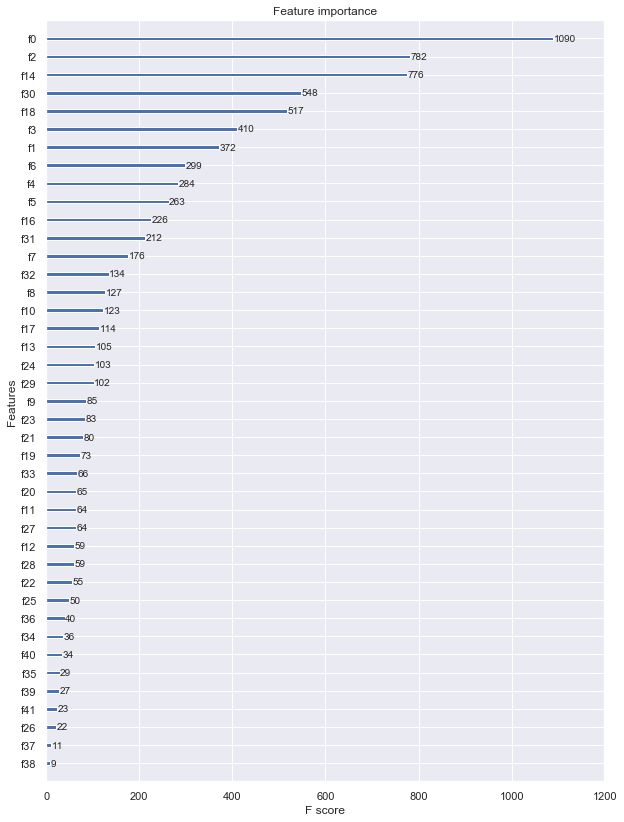

In [45]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(selector_model, (10,14))

## Train

### 全量数据进行训练

In [52]:
import xgboost as xgb

dataset_beta = dataset[(dataset.date_block_num < 32)]
train_dataset_x = features_pipeline.transform(dataset_beta)
train_dataset_x = selection.transform(train_dataset_x)
train_dataset_y = dataset_beta[label].values.ravel()
train_dmatrix = xgb.DMatrix(train_dataset_x, label=train_dataset_y)

dataset_test = dataset[(dataset.date_block_num == 33)]
test_dataset_x = features_pipeline.transform(dataset_test)
test_dataset_x = selection.transform(test_dataset_x)
test_dataset_y = dataset_test[label].values.ravel()
test_dmatrix = xgb.DMatrix(test_dataset_x, label=test_dataset_y)

dataset_valid = dataset[(dataset.date_block_num == 32)]
valid_dataset_x = features_pipeline.transform(dataset_valid)
valid_dataset_x = selection.transform(valid_dataset_x)
valid_dataset_y = dataset_valid[label].values.ravel()
valid_dmatrix = xgb.DMatrix(valid_dataset_x, label=valid_dataset_y)

In [ ]:
watchlist = [(train_dmatrix, 'train'), (valid_dmatrix, 'validate')] 

params = {
    'objective': 'reg:linear', 
    'verbose': True,
    'eta': 0.1,
    'max_depth': 12,
    'min_child_weight': 0.8,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'colsample_bylevel': 0.8,
    'eval_metric': 'rmse',
    'gamma': 0.01
}

# 使用xgb.cv优化num_boost_round参数
cvresult = xgb.cv(params, train_dmatrix, num_boost_round=10000, seed=2019, callbacks=[
    xgb.callback.print_evaluation(show_stdv=False),
    xgb.callback.early_stop(10)
])
num_round_best = cvresult.shape[0] - 1
print('Best round num: ', num_round_best)

watchlist = [(train_dmatrix, 'train'), (valid_dmatrix, 'validate')] 
model = xgb.train(params, train_dmatrix, evals=watchlist, early_stopping_rounds=10, num_boost_round=num_round_best)

[10:21:37] Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[10:25:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4770 extra nodes, 0 pruned nodes, max_depth=12
[10:25:42] Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[10:29:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4772 extra nodes, 0 pruned nodes, max_depth=12
[10:29:40] Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[10:33:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4994 extra nodes, 0 pruned nodes, max_depth=12
[0]	train-rmse:2.65568	test-rmse:2.68879
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will t

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

pred = model.predict(test_dmatrix)
sqrt(mean_squared_error(test_dataset_y, pred))

## Predict

In [ ]:
tdf = _extract(sales_detail_df, 35, is_test=True)

In [30]:
_mean(tdf, 'r')

In [31]:
for i in range(1, 13, 1):
    t = tdf.groupby(['shop_id', 'item_category_id'])['r'+str(i)].mean().reset_index(name='sc'+str(i))
    tdf = pd.merge(tdf, t, on=['shop_id', 'item_category_id'], how='left')

In [32]:
_mean(tdf, 'sc')

In [33]:
for i in range(1, 13, 1):
    t = tdf.groupby(['item_id'])['r'+str(i)].mean().reset_index(name='i'+str(i))
    tdf = pd.merge(tdf, t, on=['item_id'], how='left')

In [34]:
_mean(tdf, 'i')

In [35]:
for i in range(1, 14, 1):
    sales_record_df['sc'+str(i)] = tdf['sc'+str(i)].astype('float32')
    sales_record_df['i'+str(i)] = tdf['i'+str(i)].astype('float32')

tdf['r13'] = tdf['r13'].astype('float32')

In [50]:
dataset_predict = pd.merge(test_df, tdf, on=['item_id', 'shop_id'], how='left')

predict_dataset_x = features_pipeline.transform(dataset_predict)
predict_dataset_x = selection.transform(predict_dataset_x)

predict_dmatrix = xgb.DMatrix(predict_dataset_x)

pred = model.predict(predict_dmatrix)

/Users/leewind/.local/share/virtualenvs/leewind-p6XO93Th/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/leewind/.local/share/virtualenvs/leewind-p6XO93Th/lib/python3.7/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [51]:
submission = pd.DataFrame({
    "ID": test_df.index, 
    "item_cnt_month": pred
})

submission.to_csv('submission.csv', index=False)

# Reference

## Normal ML Analysis

+ [Feature engineering, xgboost](https://www.kaggle.com/dlarionov/feature-engineering-xgboost)
+ [Predicting sales using Lightgbm](https://www.kaggle.com/sanket30/predicting-sales-using-lightgbm)

## Time Series

对于revenge的预测很有帮助，但是对于单个店的单个商品而言没有实际的意义，这种预测方式的学习非常有益处

+ [AR(I)MA时间序列建模过程——步骤和python代码](https://www.jianshu.com/p/cced6617b423)
+ [python时间序列分析](http://www.cnblogs.com/foley/p/5582358.html)
+ [AR、MA及ARMA模型](https://zhuanlan.zhihu.com/p/22248464)
+ [Time Series with Python (ODSC) STA.ipynb](https://github.com/ultimatist/ODSC17/blob/master/Time%20Series%20with%20Python%20(ODSC)%20STA.ipynb)
+ [Getting Started with Time Series](https://pyflux.readthedocs.io/en/latest/getting_started.html)
+ [Welcome to Statsmodels’s Documentation](http://www.statsmodels.org/devel/index.html)